# Notebook for final analysis

## Import necessary libraries

In [3]:
import pandas as pd
from data.data_functions import *
from simulation.simulation_models import *
from optimization.optimization import *

## Henter nødvendige dataset

In [4]:
path = "./data/fin_hf_datagrunnlag.xlsx"
fin_data = datalast_behandling(path)
data = opt_dataset(fin_data, "medisinsk", year=2023)

# Tilbudsiden

## Optimeringsmodell for optimalt bemanningsnivå

### Setting parameters

In [5]:
df_index = data.Dato
demand = data["Antall inn på post"] + round(data["Belegg pr. dag"])
MaxStaff = 30
PPS = 4
availability = 20
ServiceLevel = 0.8

### Creating model and result

In [6]:
model = labor_scheduling(df_index, demand, MaxStaff, PPS, availability, ServiceLevel)
result, status, obj, staff_allocated = optimize_staffing(model)
data["staff_allocated"] = staff_allocated
display(data)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\Consumer\AppData\Local\Temp\tmpq0sdst3c.glpk.raw --wglp
 C:\Users\Consumer\AppData\Local\Temp\tmpuh4lt5b7.glpk.glp --cpxlp C:\Users\Consumer\AppData\Local\Temp\tmpqmq98xi4.pyomo.lp
Reading problem data from 'C:\Users\Consumer\AppData\Local\Temp\tmpqmq98xi4.pyomo.lp'...
780 rows, 260 columns, 780 non-zeros
260 integer variables, none of which are binary
3910 lines were read
Writing problem data to 'C:\Users\Consumer\AppData\Local\Temp\tmpuh4lt5b7.glpk.glp'...
3123 lines were written
GLPK Integer Optimizer 5.0
780 rows, 260 columns, 780 non-zeros
260 integer variables, none of which are binary
Preprocessing...
Objective value =   1.867000000e+03
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.4 Mb (395764 bytes)
Writing MIP solution to 'C:\Users\Consumer\AppData\Local\Temp\tmpq0sdst3c.glpk.raw'...
1049 lines were written


,Dato,Antall inn på post,Belegg pr. dag,staff_allocated
0,2023-01-02,10,27.208333,8.0
1,2023-01-03,7,25.166667,7.0
2,2023-01-04,16,25.458333,9.0
3,2023-01-05,6,28.875000,7.0
4,2023-01-06,6,24.916667,7.0
...,...,...,...,...
255,2023-12-25,8,17.875000,6.0
256,2023-12-26,6,24.750000,7.0
257,2023-12-27,14,26.250000,8.0
258,2023-12-28,11,24.500000,8.0


### Visualize results

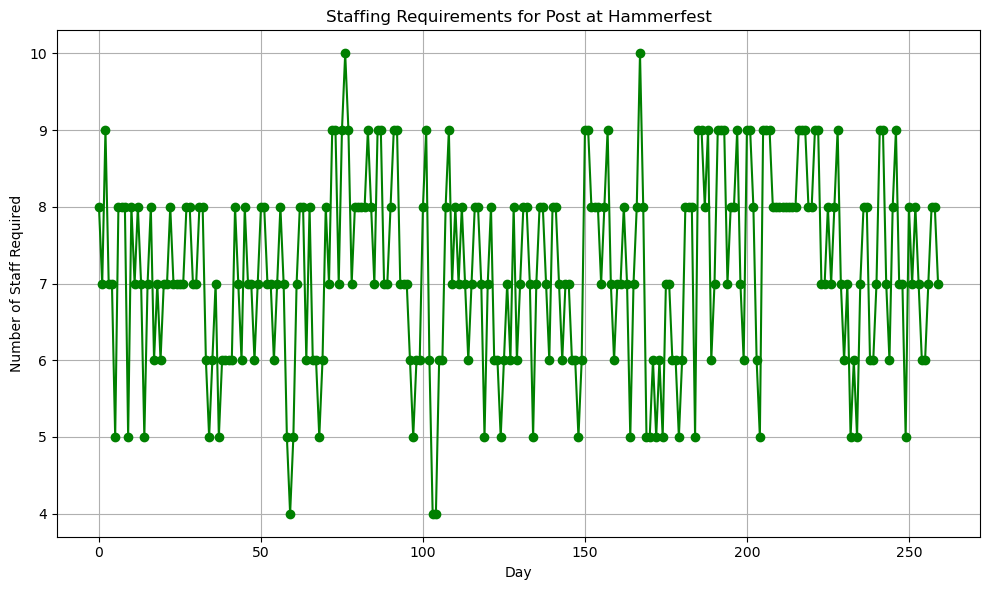

In [7]:
staff_opt_plot(staff_allocated)

## Simulering bemanningsnivåer og Skiftdesign for Over- og Underbemanninger

### Input data

In [8]:
data = fin_data
post = "medisinsk"
weekend = False
predictions = "False"
year = 2023
avg_length_of_stay = 3  # Gjennomsnittlig liggetid (dager)
patients_per_nurse = 3  # Antall pasienter per sykepleier
shifts_per_day = 3  # Antall skift per dag
iterations = 1000  # Antall simuleringer

### Simulering under/overbemannede skift

In [9]:
understaffed_shifts, overstaffed_shifts, total_shifts, staffed_shifts_data = over_under_staffed_shifts(data, 
                                                                                                       avg_length_of_stay, 
                                                                                                       patients_per_nurse, 
                                                                                                       shifts_per_day, 
                                                                                                       iterations, 
                                                                                                       post, 
                                                                                                       weekend, 
                                                                                                       predictions, 
                                                                                                       year)


prosent_underbemannet_skift = understaffed_shifts / total_shifts * 100
prosent_overbemannet_skift = overstaffed_shifts / total_shifts * 100

# Resultat: Hvor ofte er skift underbemannet?
print(f"Prosentandel skift med underbemanning: {prosent_underbemannet_skift:.2f}%")
print(f"Prosentandel skift med overbemanning: {prosent_overbemannet_skift:.2f}%")
print(f"Prosentandel skift med riktig bemanning: {(100 - (prosent_underbemannet_skift + prosent_overbemannet_skift)):.2f}%")

Prosentandel skift med underbemanning: 0.00%
Prosentandel skift med overbemanning: 100.00%
Prosentandel skift med riktig bemanning: 0.00%


### Visualiserte resultater

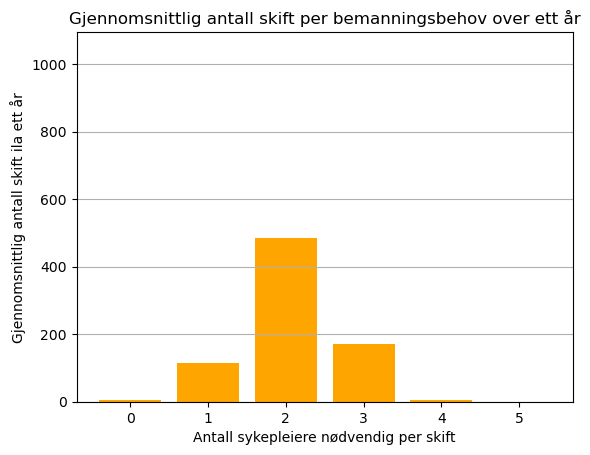

In [10]:
under_over_staffing_plot(staffed_shifts_data, iterations, shifts_per_day)

# Etterspørselsiden

## Monte Carlo Simulering Overbelastning, Belegg, og Ventetid

### Input data

In [11]:
data = fin_data 
post = "medisinsk"
weekend = False
predictions = "False"
year = 2023
total_beds = 26  
average_stay = 3 # Normal
num_simulations = 1000

### Simuleringsresultater

In [12]:
data, avg_overload_days, avg_occupancy_percentage, waiting_probability, all_overload_days, all_occupancy_percents = monte_carlo_simulation(fin_data, 
                                                                                                                                           total_beds, 
                                                                                                                                           average_stay, 
                                                                                                                                           num_simulations, 
                                                                                                                                           "medisinsk", 
                                                                                                                                           year = 2023)

# Print resultater
print(f"Gjennomsnittlig antall dager med overbelastning per år: {avg_overload_days:.2f} dager")
print(f"Gjennomsnittlig beleggsprosent over året: {avg_occupancy_percentage:.2f}%")
print(f"Sannsynligheten for at pasienter må vente på en seng: {waiting_probability:.2%}")

Gjennomsnittlig antall dager med overbelastning per år: 56.42 dager
Gjennomsnittlig beleggsprosent over året: 79.91%
Sannsynligheten for at pasienter må vente på en seng: 5.72%


### Visualiserte resultater

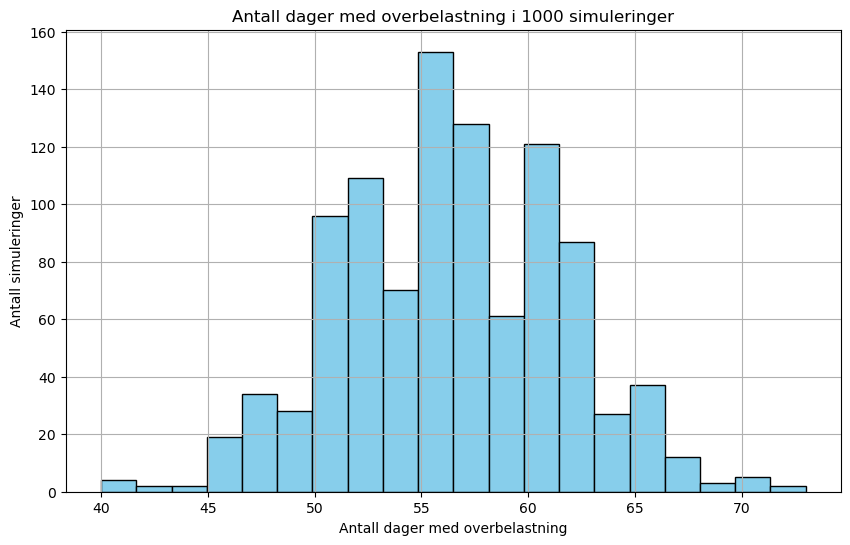

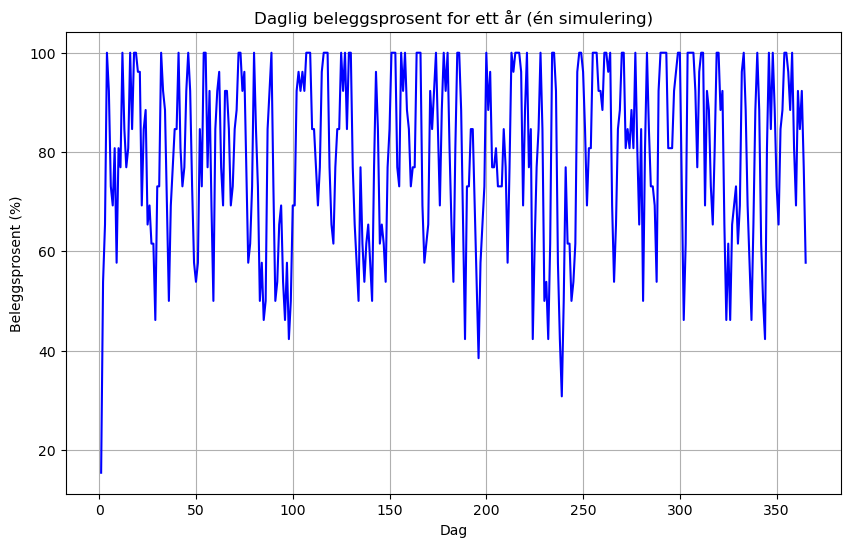

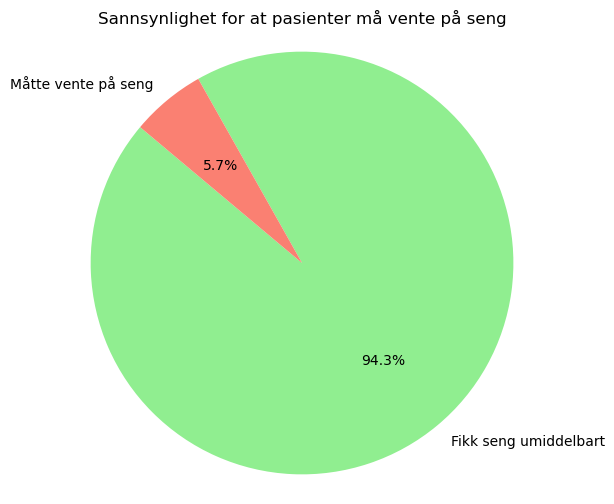

In [13]:
monte_carlo_dager_overbelastning(all_overload_days)
monte_carlo_beleggsprosent(data, all_occupancy_percents)
monte_carlo_waiting_probability(waiting_probability)